In [22]:
import json
import numpy as np
import pandas as pd

class OsdbDataLoader:
    def __init__(self, file_path, time_steps):
        self.file_path = file_path
        self.time_steps = time_steps
        self.df_sensordata = None
        self.load_and_process_data_from_json()

    def load_and_process_data_from_json(self):
        """
        Load and process OSDB data from a JSON file. This function will create a DataFrame 
        with the necessary columns and calculate FFT features.
        """
        with open(self.file_path, 'r') as file:
            raw_json = json.load(file)

        # Flatten the JSON and extract the necessary data
        flattened_data = []
        for attribute in raw_json:
            user_id = attribute.get('userId', None)
            datapoints = attribute.get('datapoints', [])

            for point in datapoints:
                event_id = point.get('eventId', None)
                hr = point.get('hr', None)
                o2Sat = point.get('o2Sat', None)
                rawData = point.get('rawData', [])
                rawData3D = point.get('rawData3D', [])

                # FFT calculation for rawData
                fft_result = self.calculate_fft(rawData)
                #Uncomment the sensor data that you want to load
                flattened_data.append({
                    'eventId': event_id,
                    'userId': user_id,
                    'hr': hr,
                    #'o2Sat': o2Sat,
                    'rawData': rawData,
                    #'rawData3D': rawData3D,
                    'FFT': fft_result  # Adding FFT column directly
                })

        # Create DataFrame from the flattened data
        self.df_sensordata = pd.DataFrame(flattened_data)

        # Apply zero padding to the FFT column to make sure all rows have 125 FFT values
        self.df_sensordata['FFT'] = self.df_sensordata['FFT'].apply(lambda fft: np.pad(fft, (0, 125 - len(fft)), 'constant', constant_values=0) if len(fft) < 125 else fft)

    def calculate_fft(self, raw_data):
        if not raw_data:
            return []

        # Convert raw_data to numpy array
        raw_data = np.array(raw_data)
        # Perform FFT, remove DC component, and return magnitudes
        raw_data = raw_data - np.mean(raw_data)  # Remove DC component
        fft_result = np.fft.fft(raw_data)
        fft_magnitude = np.abs(fft_result)
        # Isolate positive frequencies
        positive_fft_magnitude = fft_magnitude[:len(fft_magnitude) // 2]
        
        return positive_fft_magnitude.tolist()  # Return as a list


In [23]:
# Example usage:
file_path = "Data/testDataVisualisation.json"
time_steps = 125  # Assuming 100 time steps for simplicity

osdb_dl = OsdbDataLoader(file_path=file_path, time_steps=time_steps)

# Access the DataFrame with the new FFT column
#data_loader.df_sensordata['FFT'] = data_loader.df_sensordata['FFT'].apply(lambda fft: np.pad(fft, (0, 125 - len(fft)), 'constant', constant_values=0) if len(fft) < 125 else fft)

df_sensordata = osdb_dl.df_sensordata
df_sensordata.head()

,eventId,userId,hr,o2Sat,rawData,rawData3D,FFT
0,407,39,67,-1,"[1496, 1480, 1500, 1492, 1496, 1484, 1500, 149...",[],"[1.2960299500264227e-11, 143.05125737182817, 5..."
1,407,39,67,-1,"[1492, 1508, 1496, 1476, 1484, 1476, 1496, 150...",[],"[9.094947017729282e-13, 75.02350794818989, 31...."
2,407,39,68,-1,"[1488, 1496, 1484, 1492, 1492, 1508, 1504, 148...",[],"[2.2737367544323206e-13, 91.25440903139302, 81..."
3,407,39,69,-1,"[1488, 1476, 1480, 1504, 1496, 1508, 1484, 148...",[],"[1.3642420526593924e-11, 101.37768172754971, 7..."
4,407,39,69,-1,"[1504, 1488, 1504, 1492, 1484, 1500, 1496, 149...",[],"[7.275957614183426e-12, 116.42740204040989, 77..."


In [24]:
import pandas as pd
import numpy as np

class DataReshaper:
    def __init__(self, dataframe):
        self.df = dataframe

    def reshape_data(self):
        reshaped_rows = []
        
        for idx, row in self.df.iterrows():
            event_id = row['eventId']
            user_id = row['userId']
            hr = row['hr']
            o2Sat = row['o2Sat']
            rawData = row['rawData']
            rawData3D = row['rawData3D']
            fft = row['FFT']
            
            # Replicate eventId, userId, hr, o2Sat for 125 times
            repeated_info = {
                'eventId': [event_id] * 125,
                'userId': [user_id] * 125,
                'hr': [hr] * 125,
                'o2Sat': [o2Sat] * 125
            }
            
            # Transpose rawData and FFT
            rawData_transposed = rawData[:125]  # Transpose to the correct shape
            fft_transposed = fft[:125]  # Transpose to the correct shape
            
            # Process rawData3D if it exists
            if rawData3D:
                # Convert rawData3D into lists of 3 (x, y, z)
                rawData3D_transposed = [rawData3D[i:i+3] for i in range(0, len(rawData3D), 3)]
                rawData3D_transposed = rawData3D_transposed[:125]  # Ensure only 125 rows
            else:
                rawData3D_transposed = [None] * 125  # If no rawData3D, set it to None
            
            # Create the reshaped row
            for i in range(125):
                reshaped_rows.append({
                    'eventId': repeated_info['eventId'][i],
                    'userId': repeated_info['userId'][i],
                    'hr': repeated_info['hr'][i],
                    'o2Sat': repeated_info['o2Sat'][i],
                    'rawData': rawData_transposed[i],
                    'rawData3D': rawData3D_transposed[i],
                    'FFT': fft_transposed[i]
                })
        
        # Create a new DataFrame from the reshaped rows
        reshaped_df = pd.DataFrame(reshaped_rows)
        return reshaped_df

In [25]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

class Interpolator:
    def __init__(self, df, column_to_interpolate):
        """
        Initialize the Interpolator class with a DataFrame and the column to interpolate.
        """
        self.df = df
        self.column_to_interpolate = column_to_interpolate

    def interpolate_column(self, new_column_name='interpolated_hr', interval=125, time_step=5):
        """
        Interpolate the specified column using the provided logic.
        
        Parameters:
        - new_column_name: Name of the new column to store interpolated values.
        - interval: Interval to sample the original column (e.g., every 125th element).
        - time_step: Time step in seconds for the interpolation process.
        """
        try:
            # Step 1: Extract every nth element from the specified column
            original_values = self.df[self.column_to_interpolate]
            selected_elements = original_values[0::interval]
            x = np.array(selected_elements)

            # Step 2: Create an array representing the time (in `time_step` intervals)
            time_values = np.arange(len(x)) * time_step

            # Step 3: Create a CubicSpline object for interpolation
            cs = CubicSpline(time_values, x, bc_type='clamped')

            # Step 4: Generate new time values for finer granularity
            num_original_points = len(x)
            new_time_values = np.linspace(0, (num_original_points - 1) * time_step, num_original_points * interval)

            # Step 5: Generate interpolated values
            interpolated_values = cs(new_time_values)

            # Step 6: Update the DataFrame with the interpolated values
            self.df[new_column_name] = interpolated_values[:len(self.df)]  # Match the original DataFrame length

            print(f"Interpolation completed. New column '{new_column_name}' added to the DataFrame.")
        except Exception as e:
            print("An error occurred during interpolation:", e)

    def get_dataframe(self):
        """
        Return the updated DataFrame with interpolated values.
        """
        return self.df

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
from config import config

class DataLoader:
    def __init__(self, dataframe, time_steps, step, target_column):
        self.dataframe = dataframe
        self.time_steps = time_steps
        self.step = step
        self.target_column = target_column
    
    def load_data(self):
        segments = []
        labels = []
        for i in range(0, self.dataframe.shape[0] - config.N_TIME_STEPS, config.step):  
            mag = self.dataframe['rawData'].values[i: i + config.N_TIME_STEPS]
            interpolated_hr = self.dataframe['interpolated_hr'].values[i: i + config.N_TIME_STEPS]
            fft = self.dataframe['FFT'].values[i: i + config.N_TIME_STEPS]
            segment = np.column_stack((mag, interpolated_hr, fft))
            label_mode = stats.mode(self.dataframe['label'][i: i + config.N_TIME_STEPS]) #Code for Python 3.7
            #label_mode = np.unique(self.dataframe['label'][i: i + config.N_TIME_STEPS])[0] #change this line for python 3.12
            if isinstance(label_mode.mode, np.ndarray):
                label = label_mode.mode[0]
            else:
                label = label_mode.mode
            segments.append(segment)
            labels.append(label)
        segments = np.asarray(segments, dtype=np.float32)
        labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)     
        return segments, labels


In [77]:
class config:

    #Globals
    batch_size = 8
    num_classes = 3  # classes, seizure/no seizure
    epochs = 2      # Epoch iterations
    row_hidden = 64  # hidden neurons in conv layers
    col_hidden = 64   # hidden neurons in the Bi-LSTM layers
    RANDOM_SEED = 123    
    N_TIME_STEPS = 125   # 50 records in each sequence
    N_FEATURES = 3     # mag,hr,roi_Ratio,output
    step = 100           # window overlap = 50 -10 = 40  (80% overlap)
    N_CLASSES = 3       # class labels
    
if __name__ == "__main__":
    
    # Example usage:
    file_path = "Data/testDataVisualisation.json"
    time_steps = 125  # Assuming 100 time steps for simplicity
    reshaper = DataReshaper(osdb_dl.df_sensordata)
    reshaped_df = reshaper.reshape_data()
    # Initialize Interpolator and interpolate the 'hr' column
    interpolator = Interpolator(reshaped_df, column_to_interpolate="hr")
    interpolator.interpolate_column(new_column_name="interpolated_hr", interval=125, time_step=5)
    # Retrieve the updated DataFrame
    interpolated_df = interpolator.get_dataframe()

Interpolation completed. New column 'interpolated_hr' added to the DataFrame.


In [34]:
class IpdDataProcessor:
    def __init__(self, data_file, ids):
        # Initialize the class with the data file and list of event IDs
        self.data_file = data_file
        self.ids = ids
        self.df_labels = None
        self.df_sensor_data_filtered = None
        self.df_sensor_data = None
        
        # Load the data from the provided file
        self.load_data()

    def load_data(self):
        """Load data from CSV and prepare the label DataFrame."""
        # Read the CSV file
        df = pd.read_csv(self.data_file)
        
        # Select only the required columns
        self.df_labels = df[["Id", "eventId", "label"]]
        
        # Sort the labels based on 'Id'
        self.df_labels = self.df_labels.sort_values(by='Id').reset_index(drop=True)

    def filter_and_sort_sensor_data(self, interpolated_df):
        """Filter sensor data based on eventIds and sort the DataFrame."""
        # Filter the sensor data based on eventIds
        self.df_sensor_data_filtered = interpolated_df[interpolated_df['eventId'].isin(self.ids)]
        
        # Define 'eventId' as a categorical column with the desired order
        self.df_sensor_data_filtered['eventId'] = pd.Categorical(self.df_sensor_data_filtered['eventId'], categories=self.ids, ordered=True)
        
        # Sort the sensor data by 'eventId'
        self.df_sensor_data_filtered = self.df_sensor_data_filtered.sort_values('eventId')

    def merge_labels(self):
        """Merge the label column from df_labels to df_sensor_data_filtered based on eventId."""
        # Drop duplicates to ensure unique eventIds
        df_labels_unique = self.df_labels.drop_duplicates(subset='eventId', keep='first')
        
        # Merge the labels with the filtered sensor data
        self.df_sensor_data = pd.merge(self.df_sensor_data_filtered, df_labels_unique[['eventId', 'label']], on='eventId', how='left')

    def get_sensor_data(self):
        """Return the processed sensor data."""
        return self.df_sensor_data

# Example usage
if __name__ == "__main__":
    data_file = 'Scripts/ipd_dataset.csv'  # Provide your actual file path
    ids = [
        5635, 5637, 6668, 8726, 8738, 15923, 7219, 28725, 7222, 15417, 21561, 6717, 
        21569, 5705, 6732, 5721, 7258, 7772, 7262, 7775, 8800, 9828, 41062, 6761,
        44137, 6767, 5745, 115, 119, 5254, 7823, 6808, 45209, 6815, 42147, 5288,
        12973, 9401, 31420, 7357, 31421, 15039, 21695, 7365, 45781, 6884, 6897,
        9470, 8960, 5889, 5891, 9475, 7434, 8970, 21797, 8998, 9005, 4924, 24380,
        11587, 11591, 12618, 6476, 14157, 14159, 12624, 40784, 45393, 6998, 7006,
        7007, 15208, 21865, 21866, 5483, 21867, 26988, 5486, 26992, 7036, 15230,
        21886, 7044, 407, 47000, 47002, 9627, 53665, 53666, 5031, 12206, 12214,
        6587, 6590, 36799, 34756, 34759, 5580, 36812, 40913, 21458, 7125, 7126,
        8661, 26071, 5595, 5596, 12763, 26077, 5087, 5610, 6847
    ]
    
      # Create an instance of the class
    processor = SensorDataProcessor(data_file, ids)
    
    # Filter and sort the sensor data
    processor.filter_and_sort_sensor_data(interpolated_df)
    
    # Merge the labels
    processor.merge_labels()
    
    # Get the final processed sensor data
    df_sensor_data = processor.get_sensor_data()
    
    df_sensor_data.tail()


C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\1449615198.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_sensor_data_filtered['eventId'] = pd.Categorical(self.df_sensor_data_filtered['eventId'], categories=self.ids, ordered=True)


In [105]:
class DataLoader:
    def __init__(self, dataframe, time_steps, step, target_column):
        self.dataframe = dataframe
        self.time_steps = time_steps
        self.step = step
        self.target_column = target_column

    def load_data(self):
        segments = []
        labels = []
        event_ids = []
        user_ids = []

        # Group data by eventID to ensure events are kept intact
        grouped = self.dataframe.groupby('eventId')

        for event_id, group in grouped:
            if len(group) >= self.time_steps:  # Process if the event group has enough data
                for i in range(0, len(group) - self.time_steps + 1, self.step):
                    mag = group['rawData'].values[i: i + self.time_steps]
                    hr = group['interpolated_hr'].values[i: i + self.time_steps]
                    fft = group['FFT'].values[i: i + self.time_steps]
                    segment = np.column_stack((hr, mag, fft))  # Combine magnitude and heart rate features
                    label_mode = stats.mode(group[self.target_column][i: i + self.time_steps])
                    if isinstance(label_mode.mode, np.ndarray):
                        label = label_mode.mode[0]
                    else:
                        label = label_mode.mode

                    segments.append(segment)
                    labels.append(label)
                    event_ids.append(event_id)
                    user_ids.append(group['userId'].iloc[0])  # Assuming userID is consistent within an event

        # Convert to numpy arrays
        segments = np.asarray(segments, dtype=np.float32)
        labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

        # Create DataFrame to store eventID and userID alongside segments and labels
        df_labels = pd.DataFrame({
            'segments': list(segments),
            'labels': list(labels),
            'eventId': event_ids,
            'userId': user_ids
        })

        return df_labels

In [13]:
# Initialize DataLoader
data_loader = DataLoader(dataframe=df_sensor_data, time_steps=config.N_TIME_STEPS, step=config.step, target_column='label')

# Load data (this will return a DataFrame with segments, labels, eventID, and userID)
df_labels = data_loader.load_data()

NameError: name 'DataLoader' is not defined

In [107]:
class DataFormatter:
    def __init__(self, config):
        self.config = config

    def format_data(self, df_labels, priority_test_event_ids):
        # Separate priority test event IDs
        test_event_ids = set(priority_test_event_ids)
        unique_event_ids = df_labels['eventId'].unique()
        remaining_event_ids = set(unique_event_ids) - test_event_ids

        # Assign remaining events to the training set
        train_event_ids = list(remaining_event_ids)

        # Filter DataFrame for training and testing based on eventID
        df_train = df_labels[df_labels['eventId'].isin(train_event_ids)]
        df_test = df_labels[df_labels['eventId'].isin(test_event_ids)]

        # Extract segments and labels for training and testing sets
        X_train = np.asarray(df_train['segments'].tolist(), dtype=np.float32)
        y_train = np.asarray(df_train['labels'].tolist(), dtype=np.float32)
        X_test = np.asarray(df_test['segments'].tolist(), dtype=np.float32)
        y_test = np.asarray(df_test['labels'].tolist(), dtype=np.float32)

        # Reshape the segments to include feature dimension
        X_train_reshaped = self._reshape_segments(X_train)
        X_test_reshaped = self._reshape_segments(X_test)

        return X_train_reshaped, X_test_reshaped, y_train, y_test

    def _reshape_segments(self, segments):
        reshaped_segments = {}
        num_samples, num_time_steps, num_features = segments.shape
        for i in range(num_features):
            feature_name = f"Feature_{i+1}"
            reshaped_segments[feature_name] = segments[:, :, i].reshape(-1, num_time_steps, 1)
        return reshaped_segments

In [108]:
# Load data (this will return a DataFrame with segments, labels, eventID, and userID)
df_labels = data_loader.load_data()

# Specify the priority test event IDs
priority_test_event_ids = [5595, 5596, 28725, 28734, 40913, 14101,15208, 26071 ,26077 ,26988,
                           21603, 21695, 21797, 21855,  15039,
                           12618, 12624, 12763, 5635, 5637, 6668, 8726,
                           7219, 7222, 6732, 5721, 7258, 7262, 6761, 5745,
                           5254, 7823, 11591, 40784,5610]

# Initialize DataFormatter
data_formatter = DataFormatter(config)

C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\282333646.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label_mode = stats.mode(group[self.target_column][i: i + self.time_steps])


In [109]:
# Split the data by eventID into train and test sets
X_train_reshaped, X_test_reshaped, y_train, y_test = data_formatter.format_data(df_labels, priority_test_event_ids)

In [110]:
# Reshape y_test correctly
y_test_reshaped = np.asarray(y_test, dtype=np.float32)
y_train.shape

(1232, 3)

In [111]:
y_test.shape

(570, 3)

In [112]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Input, Bidirectional, Conv1D, Concatenate, Permute, Reshape, Multiply, GlobalMaxPooling1D, Attention, Activation, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from fusion import FusionLayer


class Amber_RF:
    def __init__(self, row_hidden, col_hidden, num_classes):
        self.row_hidden = row_hidden
        self.col_hidden = col_hidden
        self.num_classes = num_classes
        self.model = None

    def conv_block(self, in_layer, filters, kernel_size):
        conv = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(in_layer)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        return conv

    def lstm_pipe(self, in_layer):
        b1 = self.conv_block(in_layer, filters=64, kernel_size=3)
        b1 = MaxPooling1D(pool_size=2)(b1)
        b2 = self.conv_block(b1, filters=128, kernel_size=3)
        b2 = MaxPooling1D(pool_size=2)(b2)
        b3 = self.conv_block(b2, filters=256, kernel_size=3)
        b3 = MaxPooling1D(pool_size=2)(b3)
        encoded_rows = Bidirectional(LSTM(self.row_hidden, return_sequences=True))(b3)
        return LSTM(self.col_hidden)(encoded_rows)

    def build_model(self, num_features, input_shape):
        input_layers = []
        lstm_outputs = []
        for i in range(num_features):
            input_layer = Input(shape=input_shape, name=f'input_feature_{i+1}')
            input_layers.append(input_layer)
            lstm_output = self.lstm_pipe(Permute(dims=(1, 2))(input_layer))
            lstm_output_reshaped = Reshape((-1,))(lstm_output)  
            lstm_outputs.append(lstm_output_reshaped)  
        
        attention_outputs = []
        for i, lstm_output in enumerate(lstm_outputs):
            lstm_output_reshaped = Reshape((-1, lstm_output.shape[-1]))(lstm_output)
            attention_output = Attention()([lstm_output_reshaped, lstm_output_reshaped])
            attention_outputs.append(attention_output)
        
        weighted_features = []
        for i, (lstm_output, attention_output) in enumerate(zip(lstm_outputs, attention_outputs)):
            weighted_feature = Multiply()([lstm_output, attention_output])
            weighted_features.append(weighted_feature)
            
            
        # Replace Concatenate with FusionLayer
        fused_features = FusionLayer()(weighted_features)
        
        dense_output = Dense(128, activation='relu')(fused_features)
        dense_output = BatchNormalization()(dense_output)
        dense_output = Dropout(0.5)(dense_output)
        prediction = Dense(self.num_classes, activation='softmax')(GlobalMaxPooling1D()(fused_features))
        model = Model(inputs=input_layers, outputs=prediction)
        
        self.model = model

    def compile_model(self):
        self.model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train_list, y_train, X_val_list, y_val, epochs=10, batch_size=32):
        history = self.model.fit(X_train_list, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_list, y_val), verbose=1)
        return history

    def evaluate_model(self, X_test, y_test, batch_size=32):
        return self.model.evaluate(X_test, y_test, batch_size=batch_size)

    def predict(self, X):
        return self.model.predict(X)

    def architecture(self):
        return self.model.summary()


In [125]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (classification_report, accuracy_score, f1_score,
                             cohen_kappa_score, matthews_corrcoef, confusion_matrix)
import matplotlib.pyplot as plt
import os
import seaborn as sns

class KFoldCrossValidation:
    def __init__(self, ts_model, X_train, y_train, batch_size=config.batch_size, epochs=2, k=2, save_dir='plots'):
        self.ts_model = ts_model
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.epochs = epochs
        self.k = k
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create directory if it doesn't exist
        self.history_accumulated = {"accuracy": [], "loss": [], "val_accuracy": [], "val_loss": []}  # Initialize empty dictionaries to accumulate metrics
        self.fold_history = []  # Initialize list to store individual fold histories

    def plot_confusion_matrix(self, fold, confusion_mat):
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.savefig(os.path.join(self.save_dir, f'confusion_matrix_fold_{fold + 1}.png'))  # Save each plot with a unique filename
        plt.close()

    def plot_individual_metrics(self, fold):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots for accuracy and loss

        # Plot training accuracy
        axs[0].plot(self.fold_history[fold]['accuracy'], label='Training Accuracy')
        axs[0].plot(self.fold_history[fold]['val_accuracy'], label='Validation Accuracy')
        axs[0].set_title('Accuracy - Fold {}'.format(fold + 1))
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        # Plot training loss
        axs[1].plot(self.fold_history[fold]['loss'], label='Training Loss')
        axs[1].plot(self.fold_history[fold]['val_loss'], label='Validation Loss')
        axs[1].set_title('Loss - Fold {}'.format(fold + 1))
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'individual_metrics_fold_{fold + 1}.png'))  # Save the plot with a unique filename
        plt.close()  # Close the plot to avoid displaying it

    def plot_overall_metrics(self):
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create subplots for accuracy, validation accuracy, loss, and validation loss

        # Plot overall accuracy
        for fold in range(self.k):
            axs[0, 0].plot(range(1, self.epochs + 1), self.fold_history[fold]['accuracy'], label=f'Fold {fold + 1}')
            axs[0, 0].set_title('Accuracy')
            axs[0, 0].set_xlabel('Epoch')
            axs[0, 0].set_ylabel('Accuracy')
            axs[0, 0].legend()

        # Plot overall validation accuracy
        for fold in range(self.k):
            axs[0, 1].plot(range(1, self.epochs + 1), self.fold_history[fold]['val_accuracy'], label=f'Fold {fold + 1}')
            axs[0, 1].set_title('Validation Accuracy')
            axs[0, 1].set_xlabel('Epoch')
            axs[0, 1].set_ylabel('Accuracy')
            axs[0, 1].legend()

        # Plot overall loss
        for fold in range(self.k):
            axs[1, 0].plot(range(1, self.epochs + 1), self.fold_history[fold]['loss'], label=f'Fold {fold + 1}')
            axs[1, 0].set_title('Loss')
            axs[1, 0].set_xlabel('Epoch')
            axs[1, 0].set_ylabel('Loss')
            axs[1, 0].legend()

        # Plot overall validation loss
        for fold in range(self.k):
            axs[1, 1].plot(range(1, self.epochs + 1), self.fold_history[fold]['val_loss'], label=f'Fold {fold + 1}')
            axs[1, 1].set_title('Validation Loss')
            axs[1, 1].set_xlabel('Epoch')
            axs[1, 1].set_ylabel('Loss')
            axs[1, 1].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'overall_metrics.png'))
        plt.close()  # Close the plot to avoid displaying it

    def run(self):
        kf = KFold(n_splits=self.k, shuffle=True)
        all_test_losses = []
        all_test_accuracies = []
        for fold, (train_index, test_index) in enumerate(kf.split(self.X_train[0])):
            print(f"Fold {fold + 1}/{self.k}")
            X_fold_train = [X[train_index] for X in self.X_train]
            y_fold_train = self.y_train[train_index]
            X_fold_val = [X[test_index] for X in self.X_train]
            y_fold_val = self.y_train[test_index]
            self.ts_model.build_model(num_features=3, input_shape=(config.N_TIME_STEPS, 1))
            self.ts_model.compile_model()
            history = self.ts_model.train_model(X_fold_train, y_fold_train, X_fold_val, y_fold_val, epochs=config.epochs, batch_size=config.batch_size)
            test_loss, test_accuracy = self.ts_model.evaluate_model(X_fold_val, y_fold_val)
            all_test_losses.append(test_loss)
            all_test_accuracies.append(test_accuracy)
            print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

            # Accumulate history
            self.fold_history.append(history.history)

            # Generate confusion matrix
            y_pred_val = self.ts_model.predict(X_fold_val)
            y_pred_classes = np.argmax(y_pred_val, axis=1)
            y_true_classes = np.argmax(y_fold_val, axis=1)

            confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

            # Print confusion matrix
            print(f"Confusion Matrix for Fold {fold + 1}:\n{confusion_mat}\n")

            # Save confusion matrix plot
            self.plot_confusion_matrix(fold, confusion_mat)

            # Save individual plots
            self.plot_individual_metrics(fold)

        avg_test_loss = np.mean(all_test_losses)
        avg_test_accuracy = np.mean(all_test_accuracies)
        print(f"Average Test Loss: {avg_test_loss:.4f}, Average Test Accuracy: {avg_test_accuracy:.4f}")

        # Plot overall metrics
        #self.plot_overall_metrics()

        return self.history_accumulated

In [114]:
# Reshape y_test correctly
y_test_reshaped = np.asarray(y_test, dtype=np.float32)

# Initialize model with concat
#ts_model = Amber(row_hidden=config.row_hidden, col_hidden=config.row_hidden, num_classes=config.N_CLASSES)

# Initialize model with residual fusion layer
ts_model = Amber_RF(row_hidden=config.row_hidden, col_hidden=config.row_hidden, num_classes=config.N_CLASSES)
ts_model


In [116]:
def evaluate_model_performance(model, X_test_list, y_test_reshaped):
    # Predict classes for test data
    y_pred = model.predict(X_test_list)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_reshaped, axis=1)

    # Calculate classification metrics
    classification_report_str = classification_report(y_true_classes, y_pred_classes)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cohen_kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
    mcc = matthews_corrcoef(y_true_classes, y_pred_classes)
    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Calculate various metrics
    TP = np.diag(confusion_mat)
    FP = confusion_mat.sum(axis=0) - TP
    FN = confusion_mat.sum(axis=1) - TP
    TN = confusion_mat.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    FDR = FP / (TP + FP)
    ACC = (TP + TN) / (TP + FP + FN + TN)

    return {
        "classification_report": classification_report_str,
        "accuracy": accuracy,
        "f1": f1,
        "cohen_kappa": cohen_kappa,
        "mcc": mcc,
        "confusion_matrix": confusion_mat,
        "TPR": TPR,
        "TNR": TNR,
        "PPV": PPV,
        "NPV": NPV,
        "FPR": FPR,
        "FNR": FNR,
        "FDR": FDR,
        "ACC": ACC
    }


In [126]:
class EventMetricsEvaluator:
    def __init__(self, model, events_folder, n_time_steps=125):
        self.model = model
        self.events_folder = events_folder
        self.n_time_steps = n_time_steps
        self.metrics_summary = pd.DataFrame(columns=['CSV_File', 'EventID', 'UserID', 'Accuracy', 'Sensitivity', 'False_Positive_Rate', 'False_Negative_Rate', 'False_Alarm_Rate'])
        self.user_event_counts = {}
        self.user_metrics = {}
        self.event_metrics = []

    def calculate_metrics(self, y_true, y_pred):
        TP, TN, FP, FN = 0, 0, 0, 0

        for true_label, pred_label in zip(y_true, y_pred):
            if true_label in [1, 2]:
                if pred_label in [1, 2]:
                    TP += 1
                else:
                    FN += 1
            elif true_label == 0:
                if pred_label in [1, 2]:
                    FP += 1
                else:
                    TN += 1

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
        false_alarm_rate = FP / len(y_true) if len(y_true) > 0 else 0

        return sensitivity, false_positive_rate, false_negative_rate, false_alarm_rate

    def evaluate(self):
        csv_files = [f for f in os.listdir(self.events_folder) if f.endswith('.csv')]

        for csv_file in csv_files:
            mypath = os.path.join(self.events_folder, csv_file)
            df = pd.read_csv(mypath).fillna(-1)

            segments_acceleration = []
            segments_heart_rate = []
            labels = []
            eventIDs = []
            userIDs = []
            false_alarms = 0

            for i in range(0, len(df), self.n_time_steps):
                group = df.iloc[i:i + self.n_time_steps]
                if len(group) == self.n_time_steps:
                    segment_acceleration = group['rawData'].values
                    segment_heart_rate = group['hr'].values

                    label = group['label'].mode()[0]
                    eventIDs.append(group['eventID'].values[0])
                    userIDs.append(group['userID'].values[0])

                    segments_acceleration.append(segment_acceleration)
                    segments_heart_rate.append(segment_heart_rate)
                    labels.append(label)

            # Convert segments to numpy arrays
            segments_acceleration = np.array(segments_acceleration, dtype=np.float32).reshape(-1, self.n_time_steps, 1)
            segments_heart_rate = np.array(segments_heart_rate, dtype=np.float32).reshape(-1, self.n_time_steps, 1)

            # Model predictions
            preds = self.model.predict([segments_acceleration, segments_heart_rate])
            preds_classes = np.argmax(preds, axis=-1) if preds.ndim > 1 else preds

            # Ground truth labels
            ground_truth_labels = np.array(labels)

            # False alarms calculation
            for true_label, pred_label in zip(ground_truth_labels, preds_classes):
                if true_label in [0, 2] and pred_label == 1:
                    false_alarms += 1

            total = len(preds_classes)
            overall_false_alarm_rate = false_alarms / total if total > 0 else 0

            # Calculate metrics
            sensitivity, false_positive_rate, false_negative_rate, _ = self.calculate_metrics(ground_truth_labels, preds_classes)

            # Append to metrics summary for each event
            self.metrics_summary = self.metrics_summary.append({
                'CSV_File': csv_file,
                'EventID': eventIDs[0] if eventIDs else 'N/A',
                'UserID': userIDs[0] if userIDs else 'N/A',
                'Accuracy': None,
                'Sensitivity': sensitivity,
                'False_Positive_Rate': false_positive_rate,
                'False_Negative_Rate': false_negative_rate,
                'False_Alarm_Rate': overall_false_alarm_rate
            }, ignore_index=True)

            # Store event metrics
            self.event_metrics.append({
                'EventID': eventIDs[0] if eventIDs else 'N/A',
                'UserID': userIDs[0] if userIDs else 'N/A',
                'Sensitivity': sensitivity,
                'False_Positive_Rate': false_positive_rate,
                'False_Negative_Rate': false_negative_rate,
                'False_Alarm_Rate': overall_false_alarm_rate
            })

            # Update user-level metrics
            userID = userIDs[0] if userIDs else 'N/A'
            if userID != 'N/A':
                if userID not in self.user_metrics:
                    self.user_metrics[userID] = {'Sensitivity': 0, 'False_Positive_Rate': 0, 'False_Negative_Rate': 0, 'False_Alarm_Rate': 0, 'count': 0}

                self.user_metrics[userID]['Sensitivity'] += sensitivity
                self.user_metrics[userID]['False_Positive_Rate'] += false_positive_rate
                self.user_metrics[userID]['False_Negative_Rate'] += false_negative_rate
                self.user_metrics[userID]['False_Alarm_Rate'] += overall_false_alarm_rate
                self.user_metrics[userID]['count'] += 1

        # Save metrics summary
        self.metrics_summary.to_csv('/content/drive/MyDrive/event_metrics_summary.csv', index=False)

        # User summary
        user_summary_data = []
        for userID, metrics in self.user_metrics.items():
            if metrics['count'] > 0:
                user_summary_data.append({
                    'UserID': userID,
                    'Average_Sensitivity': metrics['Sensitivity'] / metrics['count'],
                    'Average_False_Positive_Rate': metrics['False_Positive_Rate'] / metrics['count'],
                    'Average_False_Negative_Rate': metrics['False_Negative_Rate'] / metrics['count'],
                    'Average_False_Alarm_Rate': metrics['False_Alarm_Rate'] / metrics['count'],
                })

        user_summary_df = pd.DataFrame(user_summary_data)
        user_summary_df.to_csv('user_event_metrics_summary.csv', index=False)

        # Save event metrics summary
        event_metrics_df = pd.DataFrame(self.event_metrics)
        event_metrics_df.to_csv('event_level_metrics_summary.csv', index=False)

        print("Metrics summary saved.")


In [128]:
# Create an instance of KFoldCrossValidation
kfold_cv = KFoldCrossValidation(ts_model, [X_train_reshaped['Feature_1'], X_train_reshaped['Feature_2'], X_train_reshaped['Feature_3']], y_train)

# Run the cross-validation
kfold_cv.run()

# Evaluate the model performance
evaluation_results = evaluate_model_performance(ts_model, [X_test_reshaped['Feature_1'], X_test_reshaped['Feature_2'], X_test_reshaped['Feature_3']], y_test_reshaped)

# Access individual metrics
print("Accuracy:", evaluation_results["accuracy"])
print("F1 Score:", evaluation_results["f1"])
print("Cohen's Kappa:", evaluation_results["cohen_kappa"])
print("MCC Score:", evaluation_results["mcc"])
print("TPR Score:", evaluation_results["TPR"])
print("TNR Score:", evaluation_results["TNR"])
print("PPV Score:", evaluation_results["PPV"])
print("NPV Score:", evaluation_results["NPV"])
print("FPR Score:", evaluation_results["FPR"])
print("FDR Score:", evaluation_results["FDR"])
print("FPR Score:", evaluation_results["FPR"])
print("FPR Score:", evaluation_results["classification_report"])
print("Confusion_matrix Score:", evaluation_results["confusion_matrix"])

Fold 1/2
Epoch 1/25
77/77 [==============================] - 35s 190ms/step - loss: 0.9573 - accuracy: 0.6006 - val_loss: 0.8698 - val_accuracy: 0.6575
Epoch 2/25
77/77 [==============================] - 10s 134ms/step - loss: 0.9040 - accuracy: 0.6120 - val_loss: 0.8803 - val_accuracy: 0.6575
Epoch 3/25
77/77 [==============================] - 10s 136ms/step - loss: 0.8828 - accuracy: 0.6201 - val_loss: 0.8842 - val_accuracy: 0.6591
Epoch 4/25
77/77 [==============================] - 10s 133ms/step - loss: 0.8848 - accuracy: 0.6299 - val_loss: 0.8363 - val_accuracy: 0.6737
Epoch 5/25
77/77 [==============================] - 11s 140ms/step - loss: 0.8562 - accuracy: 0.6461 - val_loss: 0.8030 - val_accuracy: 0.6705
Epoch 6/25
77/77 [==============================] - 10s 132ms/step - loss: 0.8374 - accuracy: 0.6477 - val_loss: 0.7970 - val_accuracy: 0.6851
Epoch 7/25
77/77 [==============================] - 10s 127ms/step - loss: 0.8258 - accuracy: 0.6396 - val_loss: 0.8059 - val_accurac

In [135]:
df_labels

,segments,labels,eventId,userId
0,"[[67.0, 1496.0, 1.29602995e-11], [91.765434, 1...","[1.0, 0.0, 0.0]",407,39
1,"[[85.283195, 1300.0, 4074.7393], [81.56687, 94...","[1.0, 0.0, 0.0]",407,39
2,"[[81.46036, 2704.0, 0.0], [81.480644, 1616.0, ...","[1.0, 0.0, 0.0]",407,39
3,"[[110.52215, 1524.0, 724.117], [110.54181, 148...","[1.0, 0.0, 0.0]",407,39
4,"[[92.63199, 1456.0, 0.0], [92.75681, 1480.0, 0...","[1.0, 0.0, 0.0]",407,39
...,...,...,...,...
1797,"[[98.43167, 663.759, 0.0], [98.309235, 669.100...","[1.0, 0.0, 0.0]",15923,39
1798,"[[108.03688, 1011.31995, 3853.8643], [108.0439...","[1.0, 0.0, 0.0]",15923,39
1799,"[[111.96178, 1182.3367, 2681.3542], [111.90517...","[1.0, 0.0, 0.0]",15923,39
1800,"[[109.85871, 890.501, 0.0], [109.81639, 1042.6...","[1.0, 0.0, 0.0]",15923,39


18/18 [==============================] - 1s 64ms/step


C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:32: RuntimeWarning: invalid value encountered in divide
  TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity)
C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:33: RuntimeWarning: invalid value encountered in divide
  FPR = FP / (FP + TN)  # False Positive Rate
C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:35: RuntimeWarning: invalid value encountered in divide
  FNR = FN / (TP + FN)  # False Negative Rate
C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:36: RuntimeWarning: invalid value encountered in divide
  TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:32: RuntimeWarning: invalid value encountered in divide
  TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity)
C:\Users\jamie\AppData\Local\Temp\ipykernel_9408\3061087677.py:33: RuntimeWarning: invalid value encountered in divide
  FPR = FP / (FP 

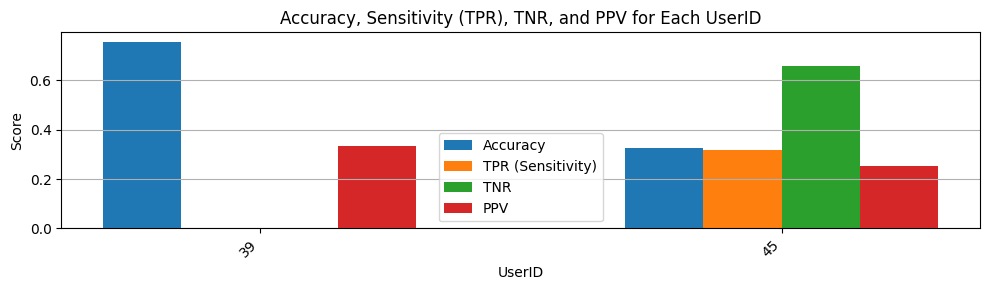

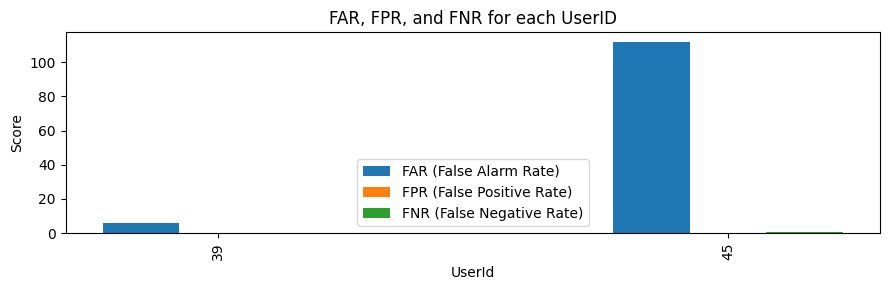

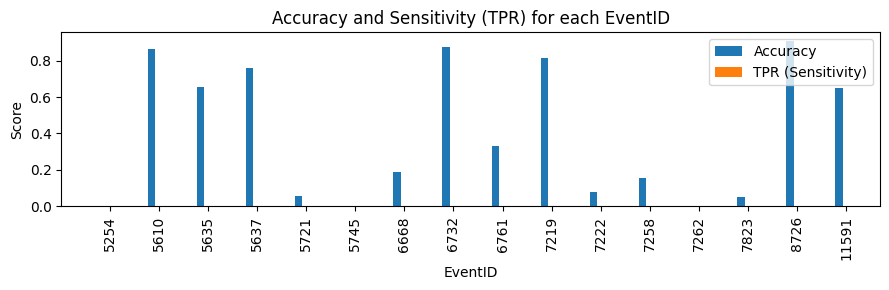

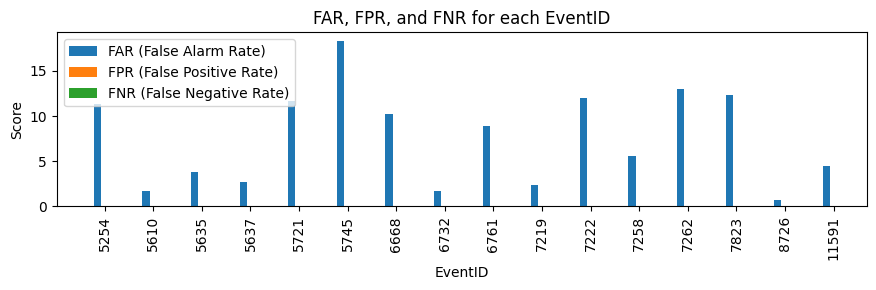

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Make predictions on the test set
y_pred = ts_model.model.predict([X_test_reshaped['Feature_1'], X_test_reshaped['Feature_2'], X_test_reshaped['Feature_3']])
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from y_test
y_true_classes = np.argmax(y_test, axis=1)

# Filter the test DataFrame by the priority event IDs
df_test = df_labels[df_labels['eventId'].isin(priority_test_event_ids)]

# Create a DataFrame for the test results
test_results_df = pd.DataFrame({
    'eventId': df_test['eventId'].values,
    'userId': df_test['userId'].values,
    'y_true': y_true_classes,
    'y_pred': y_pred_classes
})

def calculate_metrics_for_group(group):
    cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1, 2])
    accuracy = accuracy_score(group['y_true'], group['y_pred'])
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity)
    FPR = FP / (FP + TN)  # False Positive Rate
    FAR = FP+FN / (TP+FN+TN+FP)  # False Alarm Rate (different from FPR)
    FNR = FN / (TP + FN)  # False Negative Rate
    TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
    PPV = TP / (TP + FP)  # Positive Predictive Value (Precision)
    NPV = TN / (TN + FN)  # Negative Predictive Value
    FDR = FP / (TP + FP)  # False Discovery Rate
    return pd.Series({
        'accuracy': accuracy,
        'TPR': TPR.mean(),  # Average TPR across classes
        'FPR': FPR.mean(),  # Average FPR across classes
        'FAR': FAR.mean(),  # Average False Alarm Rate
        'FNR': FNR.mean(),   # Average FNR across classes
        'TP': TP,   # Average FNR across classes
        'FP': FP ,  # Average FNR across classes
        'TN': TN ,  # Average FNR across classes
        'FN': FN ,  # Average FNR across classes#
        'TNR': TNR.mean(),  # Average TNR across classes
        'PPV': PPV.mean(),  # Average PPV across classes
        'NPV': NPV.mean() ,  # Average NPV across classes
        'FDR': NPV.mean()   # Average NPV across classes


    })


# Group by userID and calculate metrics
user_metrics = test_results_df.groupby('userId').apply(calculate_metrics_for_group).reset_index()

# Group by eventID and calculate metrics
event_metrics = test_results_df.groupby('eventId').apply(calculate_metrics_for_group).reset_index()

# Convert userID and eventID to strings to treat them as categorical (no gaps between values)
user_metrics['userId'] = user_metrics['userId'].astype(str)
event_metrics['eventId'] = event_metrics['eventId'].astype(str)

# Plot grouped bar chart for userID metrics (Accuracy and TPR)
fig, ax = plt.subplots(figsize=(10, 3))  # Increased figure size for better visibility
width = 0.15  # Reduced width of the bars

# Define the positions for each bar (side by side)
x = np.arange(len(user_metrics['userId']))  # x locations for the groups

# Plotting the bars
ax.bar(x - width * 1.5, user_metrics['accuracy'], width, label='Accuracy', align='center')
ax.bar(x - width / 2, user_metrics['TPR'], width, label='TPR (Sensitivity)', align='center')
ax.bar(x + width / 2, user_metrics['TNR'], width, label='TNR', align='center')
ax.bar(x + width * 1.5, user_metrics['PPV'], width, label='PPV', align='center')

# Formatting the plot
ax.set_xlabel('UserID')
ax.set_ylabel('Score')
ax.set_title('Accuracy, Sensitivity (TPR), TNR, and PPV for Each UserID')
ax.set_xticks(x)
ax.set_xticklabels(user_metrics['userId'], rotation=45, ha='right')  # Adjust rotation for better readability
ax.legend()
plt.tight_layout()
plt.grid(axis='y')  # Optionally add gridlines for easier reading
plt.show()


# Plot grouped bar chart for userID metrics (FAR, FPR, FNR)
fig, ax = plt.subplots(figsize=(9, 3))

ax.bar(x - width, user_metrics['FAR'], width, label='FAR (False Alarm Rate)')
ax.bar(x, user_metrics['FPR'], width, label='FPR (False Positive Rate)')
ax.bar(x + width, user_metrics['FNR'], width, label='FNR (False Negative Rate)')

# Formatting the plot
ax.set_xlabel('UserId')
ax.set_ylabel('Score')
ax.set_title('FAR, FPR, and FNR for each UserID')
ax.set_xticks(x)
ax.set_xticklabels(user_metrics['userId'], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Repeat for eventID metrics

# Plot grouped bar chart for eventID metrics (Accuracy and TPR)
fig, ax = plt.subplots(figsize=(9, 3))
x = np.arange(len(event_metrics['eventId']))  # Update x for eventID
ax.bar(x - width, event_metrics['accuracy'], width, label='Accuracy')
ax.bar(x, event_metrics['TPR'], width, label='TPR (Sensitivity)')

# Formatting the plot
ax.set_xlabel('EventID')
ax.set_ylabel('Score')
ax.set_title('Accuracy and Sensitivity (TPR) for each EventID')
ax.set_xticks(x)
ax.set_xticklabels(event_metrics['eventId'], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Plot grouped bar chart for eventID metrics (FAR, FPR, FNR)
fig, ax = plt.subplots(figsize=(9, 3))

ax.bar(x - width, event_metrics['FAR'], width, label='FAR (False Alarm Rate)')
ax.bar(x, event_metrics['FPR'], width, label='FPR (False Positive Rate)')
ax.bar(x + width, event_metrics['FNR'], width, label='FNR (False Negative Rate)')

# Formatting the plot
ax.set_xlabel('EventID')
ax.set_ylabel('Score')
ax.set_title('FAR, FPR, and FNR for each EventID')
ax.set_xticks(x)
ax.set_xticklabels(event_metrics['eventId'], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()
